José Delgado

In [1]:
import dill
import os

In [2]:
model_files = [
    "ridge_gridsearch.pkl",
    "random_forest_gridsearch.pkl",
    "gradient_boosting_gridsearch.pkl",
    "xgboost_gridsearch.pkl",
]

fit_models = {}

In [3]:
for file_name in model_files:
    model_key = file_name.split("_gridsearch.pkl")[0]  # Ej: "ridge", "random_forest", etc.
    with open(f"./models/{file_name}", "rb") as f:
        fit_models[model_key] = dill.load(f)

In [4]:
print(fit_models.keys())

dict_keys(['ridge', 'random_forest', 'gradient_boosting', 'xgboost'])


# 6. Evaluate Models

## Import Evaluation Metrics

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

Ahora leemos de nuevo los datos.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv("./data/regressiondata.csv", index_col="ID")

Hacemos un debug explícito antes de entrenar, no es elegante pero es lo que hay.

In [7]:
data = data[data["HousePrice"] != "??"]

In [8]:
data = data.dropna()

## Preprocess Test Set For Predictions

Todo lo que sea eliminar filas hay que hacerlo antes del pipeline...

In [9]:
# data[data["HousePrice"] > 3000000]
# Después de la conversión nos devuelve el ID 8445, con nuestra seed

In [10]:
# Eliminar valores extremos
data = data[data["NumberOfPubs"] <= 20]
# TODO: no me deja eliminar eso porque todavía no lo convertí a float
# data = data.drop(data[data["HousePrice"] > 3000000].index)
data = data.drop(8445)

In [11]:
train, test = train_test_split(data, test_size=.3, random_state=1234)

In [12]:
X_train = train.drop(columns=["HousePrice"])
y_train = train["HousePrice"]

### Create X_test and y_test 

In [13]:
X_test = test.drop(columns=["HousePrice"])
y_test = test["HousePrice"]

In [14]:
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)

print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (6538, 5)
Forma de y_train: (6538,)
Forma de X_test: (2803, 5)
Forma de y_test: (2803,)


In [22]:
fit_models["ridge"].best_estimator_["preprocessor"].transform(X_test)

,HouseAge,DistanceToStation,NumberOfPubs,TransactionYear,TransactionMonth,PostCode_5212.0,PostCode_5213.0,PostCode_5217.0,PostCode_5222.0,PostCode_5614.0
ID,,,,,,,,,,
2251,-0.745145,-0.814844,0.997532,2019,4,0,0,0,0,0
7026,1.261652,3.365696,-1.038212,2021,5,0,0,0,0,0
7116,-1.530414,-0.765643,-1.377503,2019,8,0,0,0,0,0
9051,-0.396137,-0.688676,-1.038212,2020,11,0,0,0,0,0
4476,-0.134381,0.071265,-1.377503,2020,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6574,-0.221633,-0.022174,-1.038212,2020,1,0,0,0,0,0
8904,0.912644,-0.163912,0.997532,2021,1,0,0,0,0,0
1564,-0.134381,-0.545942,-0.020340,2020,4,0,0,0,0,0


In [25]:
fit_models["ridge"].best_estimator_.predict(X_test)

array([391841.34266832,  98996.85770816, 322399.24990103, ...,
       363159.76285118, 409799.39926058, 319028.19681594])

## Calculate Regression Metrics

In [33]:
def evaluar_modelos(fit_models, X_test, y_test):
    """
    Calcula métricas de regresión para cada modelo en fit_models y
    devuelve un diccionario con los resultados.
    """
    tabla_resultados = []

    for model_name, gridsearch in fit_models.items():
        # El mejor pipeline/estimator para ese modelo
        best_estimator = gridsearch.best_estimator_  
        
        # Predecimos sobre X_test
        y_pred = best_estimator.predict(X_test)
        
        # Calculamos métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        tabla_resultados.append([model_name, mse, rmse, mae, r2])
        
        # Convertimos la lista en DataFrame con nombres de columnas
        resultados_df = pd.DataFrame(
            tabla_resultados,
            columns=["Modelo", "MSE", "RMSE", "MAE", "R²"]
        )
    
    return resultados_df

In [ ]:
# Retraining models after deleting HousePrice outlier (ID 8445) will improve the results
evaluar_modelos(fit_models, X_test, y_test)

,Modelo,MSE,RMSE,MAE,R²
0,ridge,1.407209e+10,118625.837249,88873.763926,0.388096
1,random_forest,1.227431e+10,110789.481315,82532.482838,0.466270
2,gradient_boosting,1.040782e+10,102018.710824,76171.337137,0.547432
3,xgboost,1.027334e+10,101357.508083,75987.802246,0.553279


## Make Predictions

In [41]:
best_model = fit_models["xgboost"].best_estimator_

In [42]:
y_pred = best_model.predict(X_test)

In [45]:
results_df = y_test.to_frame()
results_df["y_pred"] = y_pred
results_df["delta"] = results_df["HousePrice"].astype(float) - results_df["y_pred"]

In [46]:
results_df

,HousePrice,y_pred,delta
ID,,,
2251,440196,383886.625000,56309.375000
7026,108901,144929.671875,-36028.671875
7116,384002,305137.218750,78864.781250
9051,368054,330863.375000,37190.625000
4476,219807,246867.218750,-27060.218750
...,...,...,...
6574,261452,250106.140625,11345.859375
8904,226820,333484.906250,-106664.906250
1564,430694,350515.343750,80178.656250


## Explain model

In [49]:
best_model

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<function y_transform at 0x111640360>,
                                            inverse_func=<function y_inverse_transform at 0x111640400>,
                                            regressor=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   ear...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=5,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=None, ...)))])

In [65]:
fit_models["gradient_boosting"].best_estimator_["transformedtargetregressor"].regressor_

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200)

In [62]:
best_model["transformedtargetregressor"].regressor_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Calculate Feature Importance

In [61]:
best_model["transformedtargetregressor"].regressor_.feature_importances_

array([0.1943775 , 0.34328008, 0.27218798, 0.16044997, 0.0297045 ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [66]:
sum(best_model["transformedtargetregressor"].regressor_.feature_importances_)

np.float32(1.0)

In [75]:
import matplotlib.pyplot as plt
import numpy as np

In [71]:
ensemble = best_model["transformedtargetregressor"].regressor_

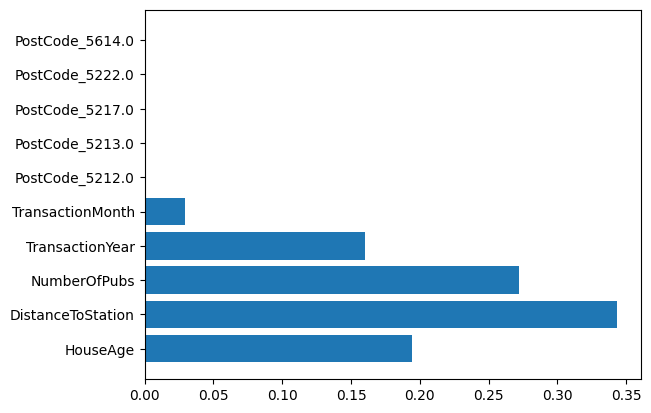

In [74]:
plt.barh(ensemble.feature_names_in_, ensemble.feature_importances_)
plt.show()

In [77]:
def plot_feature_importances(model_name, feature_importances, feature_names):
    """Grafica las importancias de las features en un barplot."""
    # Ordenamos de mayor a menor importancia
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(7, 5))
    plt.title(f"Feature Importances - {model_name}")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
    plt.xticks(range(len(feature_importances)), 
               [feature_names[i] for i in indices], 
               rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [76]:
def plot_all_importances(fit_models, feature_names):
    for model_name, gridcv in fit_models.items():
        print(f"Analizando feature importances para el modelo: {model_name}")
        best_estimator = gridcv.best_estimator_
        ttr = best_estimator["transformedtargetregressor"]
        if hasattr(ttr, "regressor_"):
            regressor_fitted = ttr.regressor_
            
            # Solo graficamos si existe 'feature_importances_'
            if hasattr(regressor_fitted, "feature_importances_"):
                importances = regressor_fitted.feature_importances_
                plot_feature_importances(model_name, importances, feature_names)
            else:
                print(f"  -> El modelo '{model_name}' no tiene feature_importances_.")
        else:
            print(f"  -> '{model_name}' no tiene un regressor_ entrenado.")

In [88]:
columnas = best_model["transformedtargetregressor"].regressor_.feature_names_in_.tolist()

Analizando feature importances para el modelo: ridge
  -> El modelo 'ridge' no tiene feature_importances_.
Analizando feature importances para el modelo: random_forest


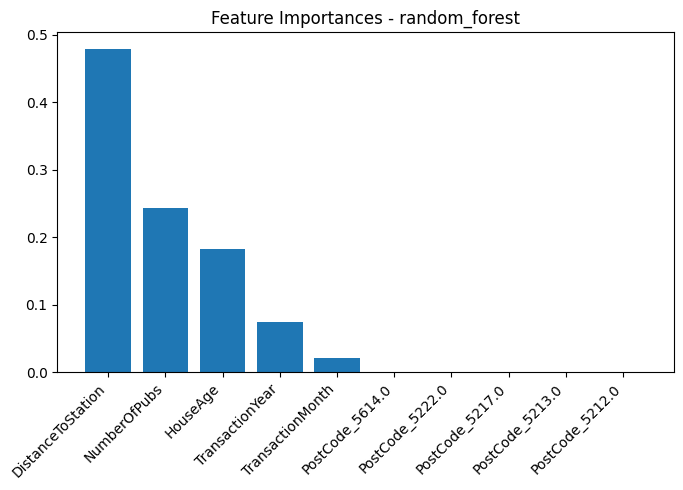

Analizando feature importances para el modelo: gradient_boosting


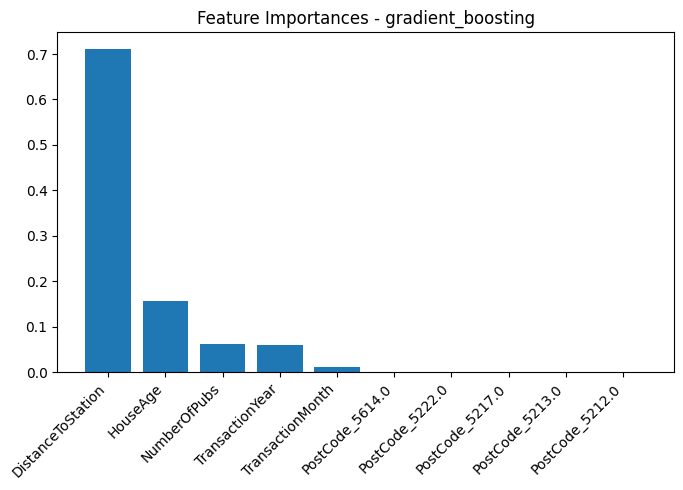

Analizando feature importances para el modelo: xgboost


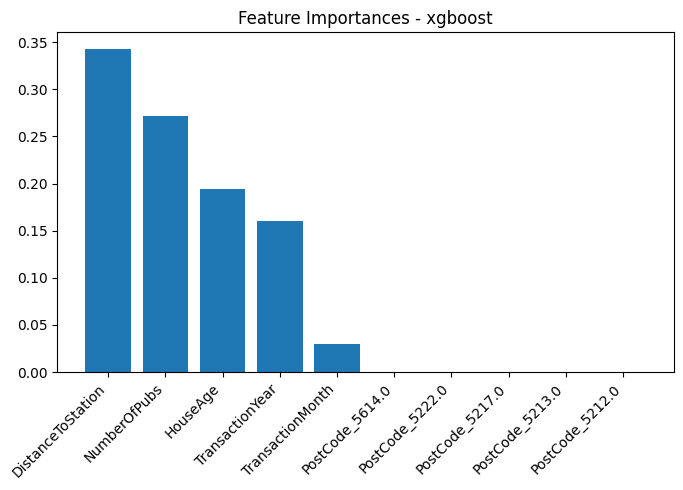

In [89]:
plot_all_importances(fit_models, columnas)

### Calculate Feature Importance for All Models

In [94]:
fit_models["ridge"].best_estimator_["transformedtargetregressor"].regressor_.coef_

array([-25652.36954897, -59172.01613576,  36849.01449936,  40405.01739607,
          210.73621025,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ])

In [96]:
new_metric = np.square(fit_models["ridge"].best_estimator_["transformedtargetregressor"].regressor_.coef_) / np.sum(np.square(fit_models["ridge"].best_estimator_["transformedtargetregressor"].regressor_.coef_))

In [97]:
new_metric

array([9.20363067e-02, 4.89707710e-01, 1.89913554e-01, 2.28336218e-01,
       6.21130047e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [98]:
sum(new_metric)

np.float64(0.9999999999999999)

### Plot Trees

# 7. Save model